In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
# import torchaudio.transforms as T

import os
import time
from utils.audio import print_stats, plot_waveform, plot_specgram, play_audio, plot_spectrogram
from dataset import AudioDataset, collate_fn
from tqdm.notebook import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device}: {torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else ''}, torch {torch.__version__}")

# data directories
train_data_path = 'data/audio'
train_label_path = 'data/label'
test_data_path = ''
test_label_path = ''

cuda: NVIDIA GeForce RTX 3060 Laptop GPU, torch 1.9.1


## Dataset

In [48]:
train_data = AudioDataset(train_data_path, train_label_path, sample_rate=8000, n_feats=12)
# test_data = AudioDataset(train_data_path, train_label_path, transform)

print(f'Train data: {len(train_data)}')
# print(f'Test data: {len(test_data)}')

Train data: 4


## DataLoader

In [49]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, collate_fn=collate_fn)
# test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True, collate_fn=collate_fn)

#### One example

Spectrogram length torch.Size([12, 40270]), label length 2851
Spectrogram length torch.Size([12, 40270]), label length 2851
Spectrogram length torch.Size([12, 40270]), label length 2851
Spectrogram length torch.Size([12, 52284]), label length 3731
torch.Size([4, 1, 12, 52284])


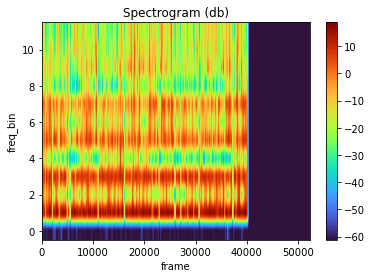

Train data shape: torch.Size([12, 52284])
Label: tensor([21, 24, 16,  ...,  0,  0,  0])


In [50]:
# Display image and label.
waveforms, train_labels, _, _ = next(iter(train_loader))
waveform = waveforms[0][0]
label = train_labels[0]

plot_spectrogram(waveform, title="MFCC", ylabel='MFCC Coefficients')
print(f'Train data shape: {waveform.shape}')
print(f"Label: {label}")

## Model

In [13]:
n_classes = 29
n_feats = 256
            
class simple_nn(nn.Module):
    hyper_parameters = {
        "n_classes": 29,
        "n_feats": 256,
#         "dropout": 0.1,
#         "hidden_size": 1024,
#         "num_layers": 1
    }
        
    def __init__(self, n_input, n_output):
        super().__init__()
        self.linear1 = nn.Linear(n_input, n_output)
        
    def forward(self, x):
        y = self.linear1(x)
        y_hat = F.relu(y)
        
        return y_hat

In [14]:
model = simple_nn(256 *52284, n_classes)
model = model.to(device)

In [15]:
# criterion = nn.CrossEntropyLoss()
criterion = nn.CTCLoss(blank=28, zero_infinity=True).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10
batch_size = 200

## Train

In [16]:
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, label, input_lengths, label_lengths) in enumerate(train_loader):
        print(input_lengths, label_lengths)
        data = data.to(device)
        label = label.to(device)
        
        print(data.shape)
        inputs = data.view(4, -1)
        print(inputs.shape)
        
        scores = model(data)
        
        loss = criterion(scores, label, input_lengths[0], label_lengths[0])
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # print training stats
        if batch_idx % log_interval == 0:
            print('epoch=',epoch)
#             print('epoch=',epoch, '\t time=', elapsed, '\t loss=', total_loss , '\t error=', total_error*100 ,'percent')
        
        # update progress bar
        pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())
        
        
log_interval = 20 # print result to screen
n_epoch = 2

# pbar_update = 1 / (len(train_loader) + len(test_loader))
pbar_update = 1 / len(train_loader)
losses = []

# # The transform needs to live on the same device as the model and the data.
# transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        shuffled_indices=torch.randperm(50000)
        
        train(model, epoch, log_interval)
#         test(model, epoch)
#         scheduler.step()

  0%|          | 0/2 [00:00<?, ?it/s]

Spectrogram length torch.Size([256, 40270]), label length 2851
Spectrogram length torch.Size([256, 52284]), label length 3731
Spectrogram length torch.Size([256, 40270]), label length 2851
Spectrogram length torch.Size([256, 40270]), label length 2851
torch.Size([4, 1, 256, 52284])
[20135, 26142, 20135, 20135] [2851, 3731, 2851, 2851]
torch.Size([4, 1, 256, 52284])


RuntimeError: view size is not compatible with input tensor's size and stride (at least one dimension spans across two contiguous subspaces). Use .reshape(...) instead.

In [ ]:
# Let's plot the training loss versus the number of iteration.
# plt.plot(losses);
# plt.title("training loss");

In [ ]:
start=time.time()

for epoch in range(160):
    
    running_loss=0
    running_error=0
    num_batches=0
    
    shuffled_indices=torch.randperm(50000)
 
    for count in range(0,50000,bs):
    
        # Set the gradients to zeros
        optimizer.zero_grad()
        
        # create a minibatch       
        indices= shuffled_indices[count:count+bs]         # COMPLETE HERE
        minibatch_data = train_data[indices] # COMPLETE HERE
        minibatch_label= train_label[indices] # COMPLETE HERE
        
        # send the minibatch to the gpu
        minibatch_data= minibatch_data.to(device) # COMPLETE HERE
        minibatch_label= minibatch_label.to(device) # COMPLETE HERE
        
        # reshape the minibatch
        inputs = minibatch_data.view(bs, -1) # COMPLETE HERE

        # tell Pytorch to start tracking all operations that will be done on "inputs"
        inputs.requires_grad_()

        # forward the minibatch through the net 
        scores= net(inputs) # COMPLETE HERE 

        # Compute the average of the losses of the data points in the minibatch
        loss = criterion(scores, minibatch_label) # COMPLETE HERE 
        
        # backward pass to compute dL/dU, dL/dV and dL/dW   
        loss.backward()

        # do one step of stochastic gradient descent: U=U-lr(dL/dU), V=V-lr(dL/dU), ...
        optimizer.step()
        
        # START COMPUTING STATS
        
        # add the loss of this batch to the running loss
        running_loss += loss.detach().item()
        
        # compute the error made on this batch and add it to the running error       
        error = utils.get_error( scores.detach() , minibatch_label)
        running_error += error.item()
        
        num_batches+=1
    
    
    # compute stats for the full training set
    total_loss = running_loss/num_batches
    total_error = running_error/num_batches
    elapsed = time.time()-start
    
    if epoch%20 == 0:
        print('epoch=',epoch, '\t time=', elapsed, '\t loss=', total_loss , '\t error=', total_error*100 ,'percent')
        eval_on_test_set() 
        print(' ')
    
    
        
        